In [1]:
!nvidia-smi
!python -V

# Stable pins for Kaggle (Python 3.10) that work with PyCaret 3.3.x
!pip -q install -U pip setuptools wheel
!pip -q install "pycaret==3.3.2" "gradio>=4,<5"

# sanity import
import sys, pycaret
print("Python:", sys.version.split()[0], "| PyCaret:", pycaret.__version__)

Thu Oct 23 19:29:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd

# Primary: Mall Customers (tiny, classic clustering dataset)
url = "https://raw.githubusercontent.com/plotly/datasets/master/mall_customers.csv"
try:
    df = pd.read_csv(url)
    # standardize column names
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    # keep a compact set of useful columns
    use_cols = ["gender","age","annual_income","spending_score"]
    # some versions name columns slightly differently – normalize:
    rename_map = {"annual_income_(k$)":"annual_income","spending_score_(1-100)":"spending_score"}
    df = df.rename(columns=rename_map)
    df = df[use_cols].dropna().reset_index(drop=True)
    source = "mall_customers"
except Exception:
    # Fallback: Seaborn tips (tiny); we’ll cluster on total_bill, tip, size
    import seaborn as sns
    tips = sns.load_dataset("tips").dropna()
    df = tips[["total_bill","tip","size","sex","smoker","day","time"]].reset_index(drop=True)
    source = "tips_fallback"

print("Source:", source, "| Shape:", df.shape)
df.head()


Source: tips_fallback | Shape: (244, 7)


,total_bill,tip,size,sex,smoker,day,time
0,16.99,1.01,2,Female,No,Sun,Dinner
1,10.34,1.66,3,Male,No,Sun,Dinner
2,21.01,3.50,3,Male,No,Sun,Dinner
3,23.68,3.31,2,Male,No,Sun,Dinner
4,24.59,3.61,4,Female,No,Sun,Dinner


In [3]:
import pandas as pd

# Identify numeric + small categoricals (<= 8 unique levels)
num_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and df[c].nunique() <= 8]

work = df[num_cols + cat_cols].copy()
for c in cat_cols:
    work[c] = work[c].astype(str)

print("Numeric:", num_cols)
print("Categorical (encoded):", cat_cols)
print("Final shape:", work.shape)
work.head()


Numeric: ['total_bill', 'tip', 'size']
Categorical (encoded): ['sex', 'smoker', 'day', 'time']
Final shape: (244, 7)


,total_bill,tip,size,sex,smoker,day,time
0,16.99,1.01,2,Female,No,Sun,Dinner
1,10.34,1.66,3,Male,No,Sun,Dinner
2,21.01,3.50,3,Male,No,Sun,Dinner
3,23.68,3.31,2,Male,No,Sun,Dinner
4,24.59,3.61,4,Female,No,Sun,Dinner


In [4]:
from pycaret.clustering import *

s = setup(
    data=work,
    session_id=42,
    normalize=True,     # helps KMeans
    verbose=False
)

# Try KMeans with a small k; adjust if silhouette looks poor
k5 = create_model("kmeans", num_clusters=5)
k5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3232,73.9575,1.3402,0,0,0


KMeans(n_clusters=5, random_state=42)

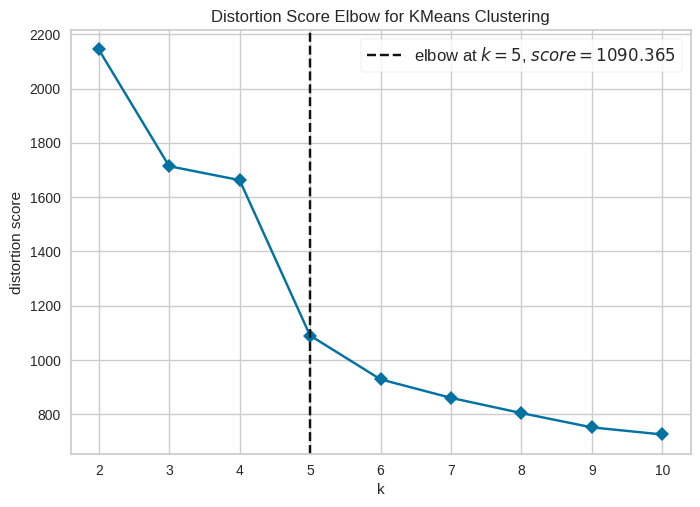

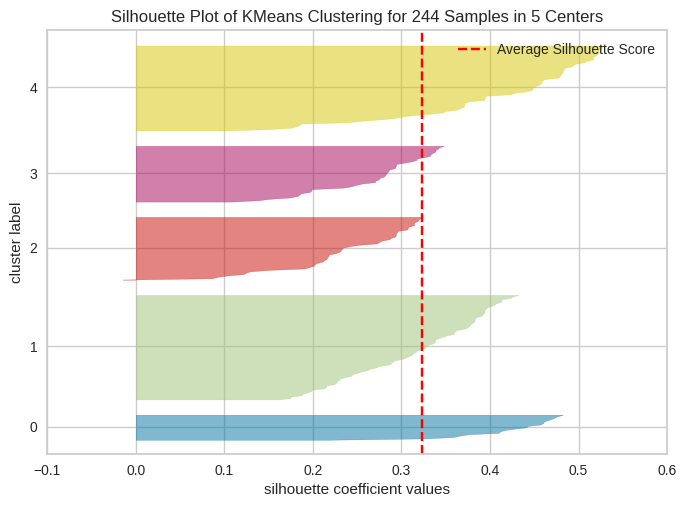

In [5]:
# Attach cluster labels back to data
labeled = assign_model(k5)
labeled.head()

# Useful visuals
plot_model(k5, plot="elbow")        # inertia vs k (diagnostic)
plot_model(k5, plot="silhouette")   # silhouette score distribution
plot_model(k5, plot="tsne")         # 2D projection


In [6]:
import os
os.makedirs("/kaggle/working/media/figures", exist_ok=True)
os.makedirs("/kaggle/working/notebooks", exist_ok=True)

# Save labeled dataset and model
labeled.to_csv("/kaggle/working/media/figures/clustering_labels.csv", index=False)
save_model(k5, "/kaggle/working/notebooks/clustering_kmeans_k5")

print("Saved:")
print("- /kaggle/working/media/figures/clustering_labels.csv")
print("- /kaggle/working/notebooks/clustering_kmeans_k5.pkl")


Transformation Pipeline and Model Successfully Saved
Saved:
- /kaggle/working/media/figures/clustering_labels.csv
- /kaggle/working/notebooks/clustering_kmeans_k5.pkl
